In [1]:
%matplotlib notebook

import numpy as np

import matplotlib.pyplot as plt


from dustpy import constants as c
from dustpy import hdf5writer
from dustpy import plot
hdf5writer = hdf5writer()


import os
import sys


<IPython.core.display.Javascript object>


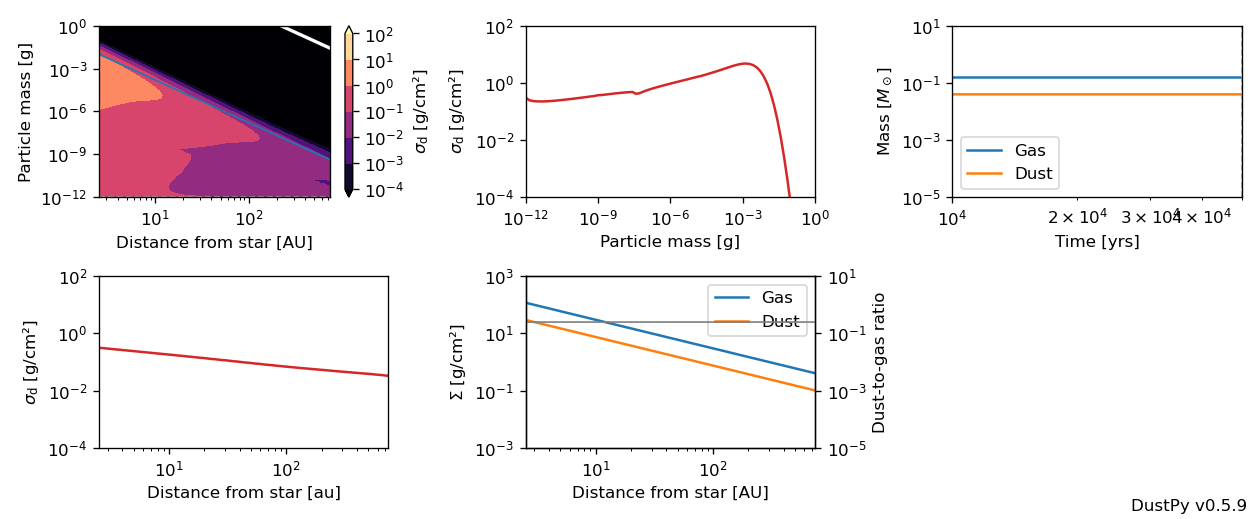

In [2]:
plot.panel("Simulation_BuildUp/", it = 5)

<IPython.core.display.Javascript object>


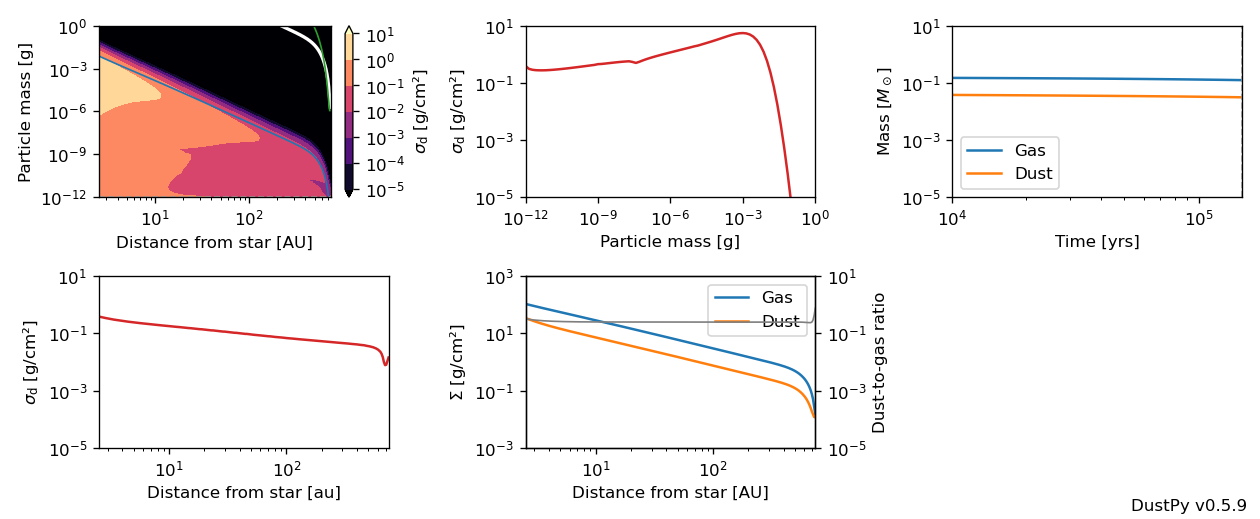

In [3]:
plot.panel("Simulation_PowerLaw/", it = 15)

In [2]:
sp = 17
plt.rc('font', size=sp)                # controls default text sizes
plt.rc('axes', titlesize=sp)           # fontsize of the axes title
plt.rc('axes', labelsize=sp)           # fontsize of the x and y labels
plt.rc('xtick', labelsize=sp)          # fontsize of the tick labels
plt.rc('ytick', labelsize=sp)          # fontsize of the tick labels
plt.rc('legend', fontsize=sp)          # legend fontsize

plt.rc('lines', linewidth=2)

height = 5
width = 8


# Benchmark - Steady-State Solution (Gárate et al. 2020, Appendix A)

## Accretion in a backreaction simulation with moderate Stokes number can be interpreted as a standard viscous advection with a different alpha viscosity

## $\mathrm{St} < \alpha \ll 1$

## The equivalent alpha viscosity is between the limit with small particles only and particles in the fragmentation limit
# $\alpha_\textrm{eq, max} = \alpha / (\epsilon +1)$ 
# $\alpha_\textrm{eq, min} =  \frac{1}{\epsilon +1}\alpha - \frac{11}{12} \frac{\epsilon}{(\epsilon +1)^2} \mathrm{St}_\textrm{frag}$

In [3]:
def alpha_equivalent(alpha = 1.e-2, d2g = 0.25, St = 5.e-3, no_growth = False):
    if no_growth:
        return alpha / (1.  + d2g)
        
    
    return alpha / (1.  + d2g) -  (11./12.) * St * d2g / (d2g + 1.0)**2.0


## The mass accretion rate of a steady state disk is defined as:
## $\dot{M} = 3 \pi \alpha_\textrm{eq} c_s^2 \Omega_K^{-1} \Sigma_g$

In [4]:
def accretion(alpha, cs, omega_k, Sigma):
    return 3 * np.pi * alpha * cs**2 * Sigma / omega_k

## Plots

In [42]:
xlims=[10, 250]
def BenchmarkPlot_SurfaceDensity(sim):
    
    # Plot the gas surface density evolution, which should remain constant in steady-state
    plt.figure(figsize=(width, height))
    plt.xlim(xlims)
    plt.ylim([1.e0, 2.e2])
    
    for i in range(sim.t.size):
        alpha = 0.1 + 0.9 *i/(sim.t.size-1)
        plt.plot(sim.grid.r[i]/c.au, sim.gas.Sigma[i], 'k:', alpha = alpha)    
    plt.plot([1, 100], [1.e6,1.e6],'k:', label = "Simulation")

    plt.xlabel("r (AU)")
    plt.ylabel(r"$\Sigma_g$ (g cm$^{-2}$)")

    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.tight_layout()


    # Plot the residual evolution over time
    plt.figure(figsize=(width, height))
    plt.xlim(xlims)
    plt.ylim([1.e-4, 1.e-1])
    for i in range(1, sim.t.size):
        alpha = 0.1 + 0.9 *i/(sim.t.size-1)
        residual = np.fabs((sim.gas.Sigma[i] - sim.gas.Sigma[0])/ sim.gas.Sigma[0])
        plt.plot(sim.grid.r[i]/c.au, residual, 'k:', alpha = alpha)


    plt.xlabel("r (AU)")
    plt.ylabel(r"$\Delta \Sigma / \Sigma_0$")
    plt.xscale('log')
    plt.yscale('log')
    plt.tight_layout()
    
    
def BenchmarkPlot_AlphaEq(sim):
    # Plot the Equivalent-Alphas
    
    # Obtain the minimum and upper limits for the equivalent alpha.
    St_frag = (sim.dust.v.frag / sim.gas.cs)**2 /(3. * sim.dust.delta.turb)
    alpha_eq_max = alpha_equivalent(sim.gas.alpha[0], sim.dust.eps[0], no_growth=True)
    alpha_eq_min = alpha_equivalent(sim.gas.alpha[0], sim.dust.eps[0], St = St_frag[0])

    # Get an estimate of the equivalent alpha using the mass weighted Stokes number
    St_w = (sim.dust.Sigma * sim.dust.St).sum(axis = -1) / sim.dust.Sigma.sum(axis = -1) 
    alpha_eq = alpha_equivalent(sim.gas.alpha, sim.dust.eps, St_w)

    
    plt.figure(figsize=(width, height))
    plt.xlim(xlims)
    plt.ylim([7.4e-3, 8.1e-3])
    for i in range(sim.t.size):
        alpha = 0.1 + 0.9 *i/(sim.t.size-1)
        plt.plot(sim.grid.r[i]/c.au, alpha_eq[i], 'k:', alpha = alpha)    
    plt.plot(sim.grid.r[0]/c.au, alpha_eq_max, 'r-', label = r"$\alpha_{eq, max}$")
    plt.plot(sim.grid.r[0]/c.au, alpha_eq_min, 'b-', label = r"$\alpha_{eq, min}$")

    plt.plot([1, 100], [1.e6,1.e6],'k:', label = "Simulation")

    plt.xlabel("r (AU)")
    plt.ylabel(r"$\alpha_{Eq}$")

    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.tight_layout()
    
    
    
    
    # Plot the Mass Accretion Rate
    Macc = -2 * np.pi * sim.grid.r * sim.gas.Sigma * sim.gas.v.rad
    Macc_max = accretion(alpha_eq_max, sim.gas.cs[0], sim.grid.OmegaK[0], sim.gas.Sigma[0])
    Macc_min = accretion(alpha_eq_min, sim.gas.cs[0], sim.grid.OmegaK[0], sim.gas.Sigma[0])
    Macc_eq = accretion(alpha_eq[0], sim.gas.cs[0], sim.grid.OmegaK[0], sim.gas.Sigma[0])
        
    plt.figure(figsize=(width, height))
    plt.xlim(xlims)
    plt.ylim([1.6e-8, 1.8e-8])
    for i in range(sim.t.size):
        alpha = 0.1 + 0.9 *i/(sim.t.size-1)
        plt.plot(sim.grid.r[i]/c.au, Macc[i] / (c.M_sun/c.year), 'k:', alpha = alpha)    

        
    plt.plot(sim.grid.r[0]/c.au, Macc_max / (c.M_sun/c.year), 'r-', label = r"$\dot{M}(\alpha_{eq, max})$")
    plt.plot(sim.grid.r[0]/c.au, Macc_min / (c.M_sun/c.year), 'b-', label = r"$\dot{M}(\alpha_{eq, min})$")
    plt.plot(sim.grid.r[0]/c.au, Macc_eq / (c.M_sun/c.year), 'k-', label = r"$\dot{M}(\alpha_{eq})$")

    
    plt.plot([1, 100], [1.e6,1.e6],'k:', label = "Simulation")

    plt.xlabel("r (AU)")
    plt.ylabel(r"$\dot{M}\, (M_\odot yr^{-1})$")

    plt.xscale('log')
    plt.yscale('linear')
    plt.legend()
    plt.tight_layout()
    
    
    
    
def BenchmarkPlot_BackreactionCoefficients(sim):
    # Plot the Equivalent-Alphas
    plt.figure(figsize=(width, height))
    plt.xlim(xlims)
    plt.ylim([1e-4, 1e-2])
    for i in range(sim.t.size):
        alpha = 0.1 + 0.9 *i/(sim.t.size-1)
        plt.plot(sim.grid.r[i]/c.au, sim.dust.backreaction.A[i] * sim.gas.alpha[i], 'r:', alpha = alpha)            
        plt.plot(sim.grid.r[i]/c.au, sim.dust.backreaction.B[i], 'b:', alpha = alpha)    

    plt.plot([1, 100], [1.e6,1.e6],'r:', label = r"$\alpha\cdot$ A")
    plt.plot([1, 100], [1.e6,1.e6],'b:', label = r"B")

    
    plt.xlabel("r (AU)")
    plt.ylabel("")

    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.tight_layout()
        
    

In [11]:
hdf5writer.datadir = "Simulation_PowerLaw/"
sim = hdf5writer.read.all()

# The goal of the test is for the simulation to resemble a steady-state solution

## We plot the simulation between 10 - 250 AU. 
### The region between 2.5 - 10 AU is ignored since we expect errors to arise at the inner boundary.

<IPython.core.display.Javascript object>


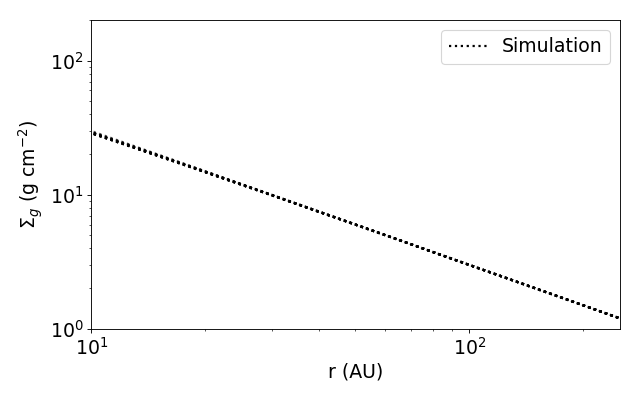

<IPython.core.display.Javascript object>


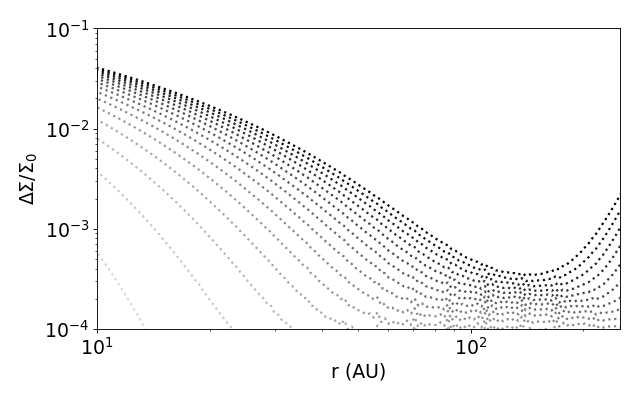

In [33]:
BenchmarkPlot_SurfaceDensity(sim)

## From the  Surface density evolution until 0.15 Myrs.

### We notice deviations from the steady state solution of a few %, propagating from the inner boundary.

<IPython.core.display.Javascript object>


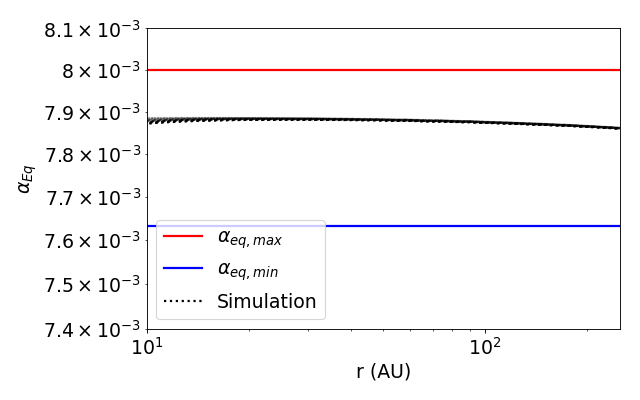

<IPython.core.display.Javascript object>


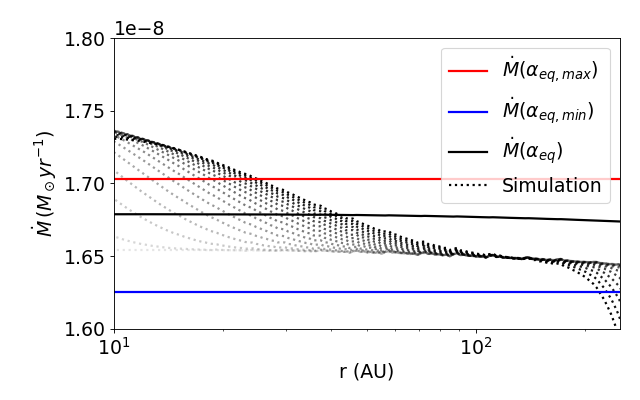

In [34]:
BenchmarkPlot_AlphaEq(sim)

### The deviations from steady state occures because the mass accretion rate (and the effective alpha) are not perfectily constant with radius at the beginning of the simulation.


### Small variations in the back-reaction pussing effect, which occur because the effective stokes number is not perfectly constant when considering a dust distribution with growth, cause a variable accretion profile that has noticeable effects in the inner boundary.


### We can find more clues in the backreaction coefficients. If these are not initially constant, it is then expected to find the deaviations from steady state seen above.

<IPython.core.display.Javascript object>


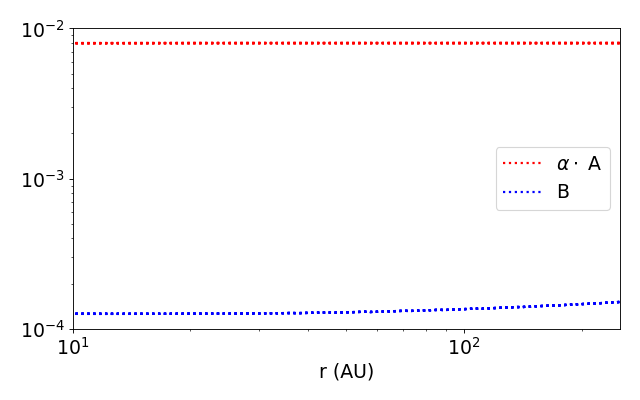

In [53]:
BenchmarkPlot_BackreactionCoefficients(sim)

### We highlight that this the deviation from steady state is then, a physical limitation from the variations in the Stokes number and in the back-reaction coefficients